In [142]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import re
import string
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from wordcloud import WordCloud,STOPWORDS
import itertools
from sklearn.metrics import classification_report
import ipywidgets as widgets

In [143]:
#download stopwords from NLTK
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [144]:
#import dataset
df_love = pd.read_csv(r'C:\Users\Shin\Documents\UM\UM\Year 2 Sem 2\WID3006 Machine Learning\Assignment\final_loveletter.csv')

#separate love letter and non-love letter into two dataframe
df_nonlove = df_love.loc[df_love['labels'] == 0]
df_onlylove = df_love.loc[df_love['labels'] == 1]

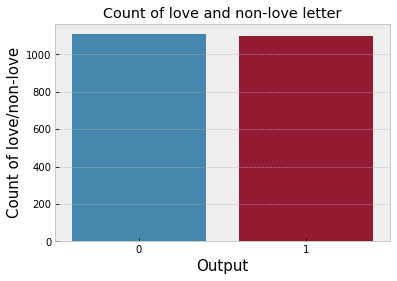

In [145]:
#showing amount of data after undersampling 
ax=sns.countplot(x="labels", data=df_love)

#Setting labels and font size
ax.set(xlabel='Output', ylabel='Count of love/non-love',title='Count of love and non-love letter')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

In [146]:
#create a copy of the dataset for data cleaning
clean_letter=df_love.copy()

In [147]:
#Make text lowercase, remove text in square brackets,remove punctuation and remove words containing numbers.
def review_cleaning(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [148]:
#create a list of stop words from NLTK
stop = stopwords.words('english')

#'doe' is a person's name used in the dataset, it is removed to increase accuracy
stop.append('doe')

In [149]:
#removing stop words
clean_letter['text'] = clean_letter['text'].apply(lambda x:review_cleaning(x))
clean_letter['text'] = clean_letter['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [150]:
#data cleaning for only love letter data
clean_onlylove = df_onlylove.copy()
clean_onlylove['text'] = clean_onlylove['text'].apply(lambda x:review_cleaning(x))
clean_onlylove['text'] = clean_onlylove['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [151]:
#data cleaning for non-love letter data
clean_nonlove = df_nonlove.copy()
clean_nonlove['text'] = clean_nonlove['text'].apply(lambda x:review_cleaning(x))
clean_nonlove['text'] = clean_nonlove['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

C:\Users\Shin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\Shin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\Shin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



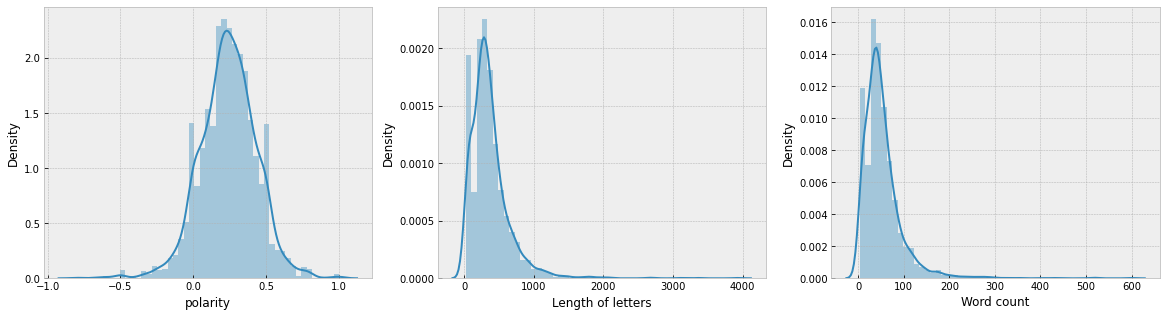

In [152]:
#Extracting the features from the letter
clean_letter['polarity'] = clean_letter['text'].map(lambda text: TextBlob(text).sentiment.polarity)
clean_letter['Length of letters'] = clean_letter['text'].astype(str).apply(len)
clean_letter['Word count'] = clean_letter['text'].apply(lambda x: len(str(x).split()))

#Plotting the distribution of the extracted feature
plt.figure(figsize = (20, 5))
plt.style.use('bmh')

#Show the graph of polarity
plt.subplot(131)
sns.distplot(clean_letter['polarity'])
fig = plt.gcf()

#Show the graph of length of letters
plt.subplot(132)
sns.distplot(clean_letter['Length of letters'])
fig = plt.gcf()

#show the graph of word count
plt.subplot(133)
sns.distplot(clean_letter['Word count'])
fig = plt.gcf()

In [153]:
#Function to get top n words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_words(clean_letter['text'], 20)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)

#Creating the dataframe of word and frequency
df = pd.DataFrame(common_words, columns = ['text' , 'frequency'])

#Group by words and plot the sum
df.groupby('text').sum()['frequency'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='frequency', linecolor='black', title='Top 20 words in letters')

love 2802
know 1421
would 930
want 899
life 895
time 841
heart 772
one 763
us 748
feel 735
much 708
always 677
never 662
like 656
day 650
please 609
could 576
make 537
thank 528
every 524


In [158]:
#words from love letters are extracted
onlylove_words = get_top_n_words(clean_onlylove['text'])
df_onlylove_words = pd.DataFrame(onlylove_words,columns=('text','frequency'))

#calculating total words count from love letter
total = 0
for word,freq in onlylove_words:
    total += freq
print("Total number of words in love letter:",total)

#plotting graph of top 20 words from love letter
list_onlylove = df_onlylove_words[:20]
df = pd.DataFrame(list_onlylove, columns=('text','frequency'))
df.groupby('text').sum()['frequency'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='frequency', linecolor='black', title='Top 20 words in love letters')

#print top 20 words from love letter
print(list_onlylove)

Total number of words in love letter: 64423


        text  frequency
0       love       2788
1       know       1133
2       life        862
3       want        764
4      heart        757
5      never        630
6       feel        627
7        day        592
8       much        585
9        one        583
10    always        580
11      time        519
12     would        515
13     could        485
14      like        476
15     every        469
16      ever        418
17  together        412
18      dont        403
19        us        389


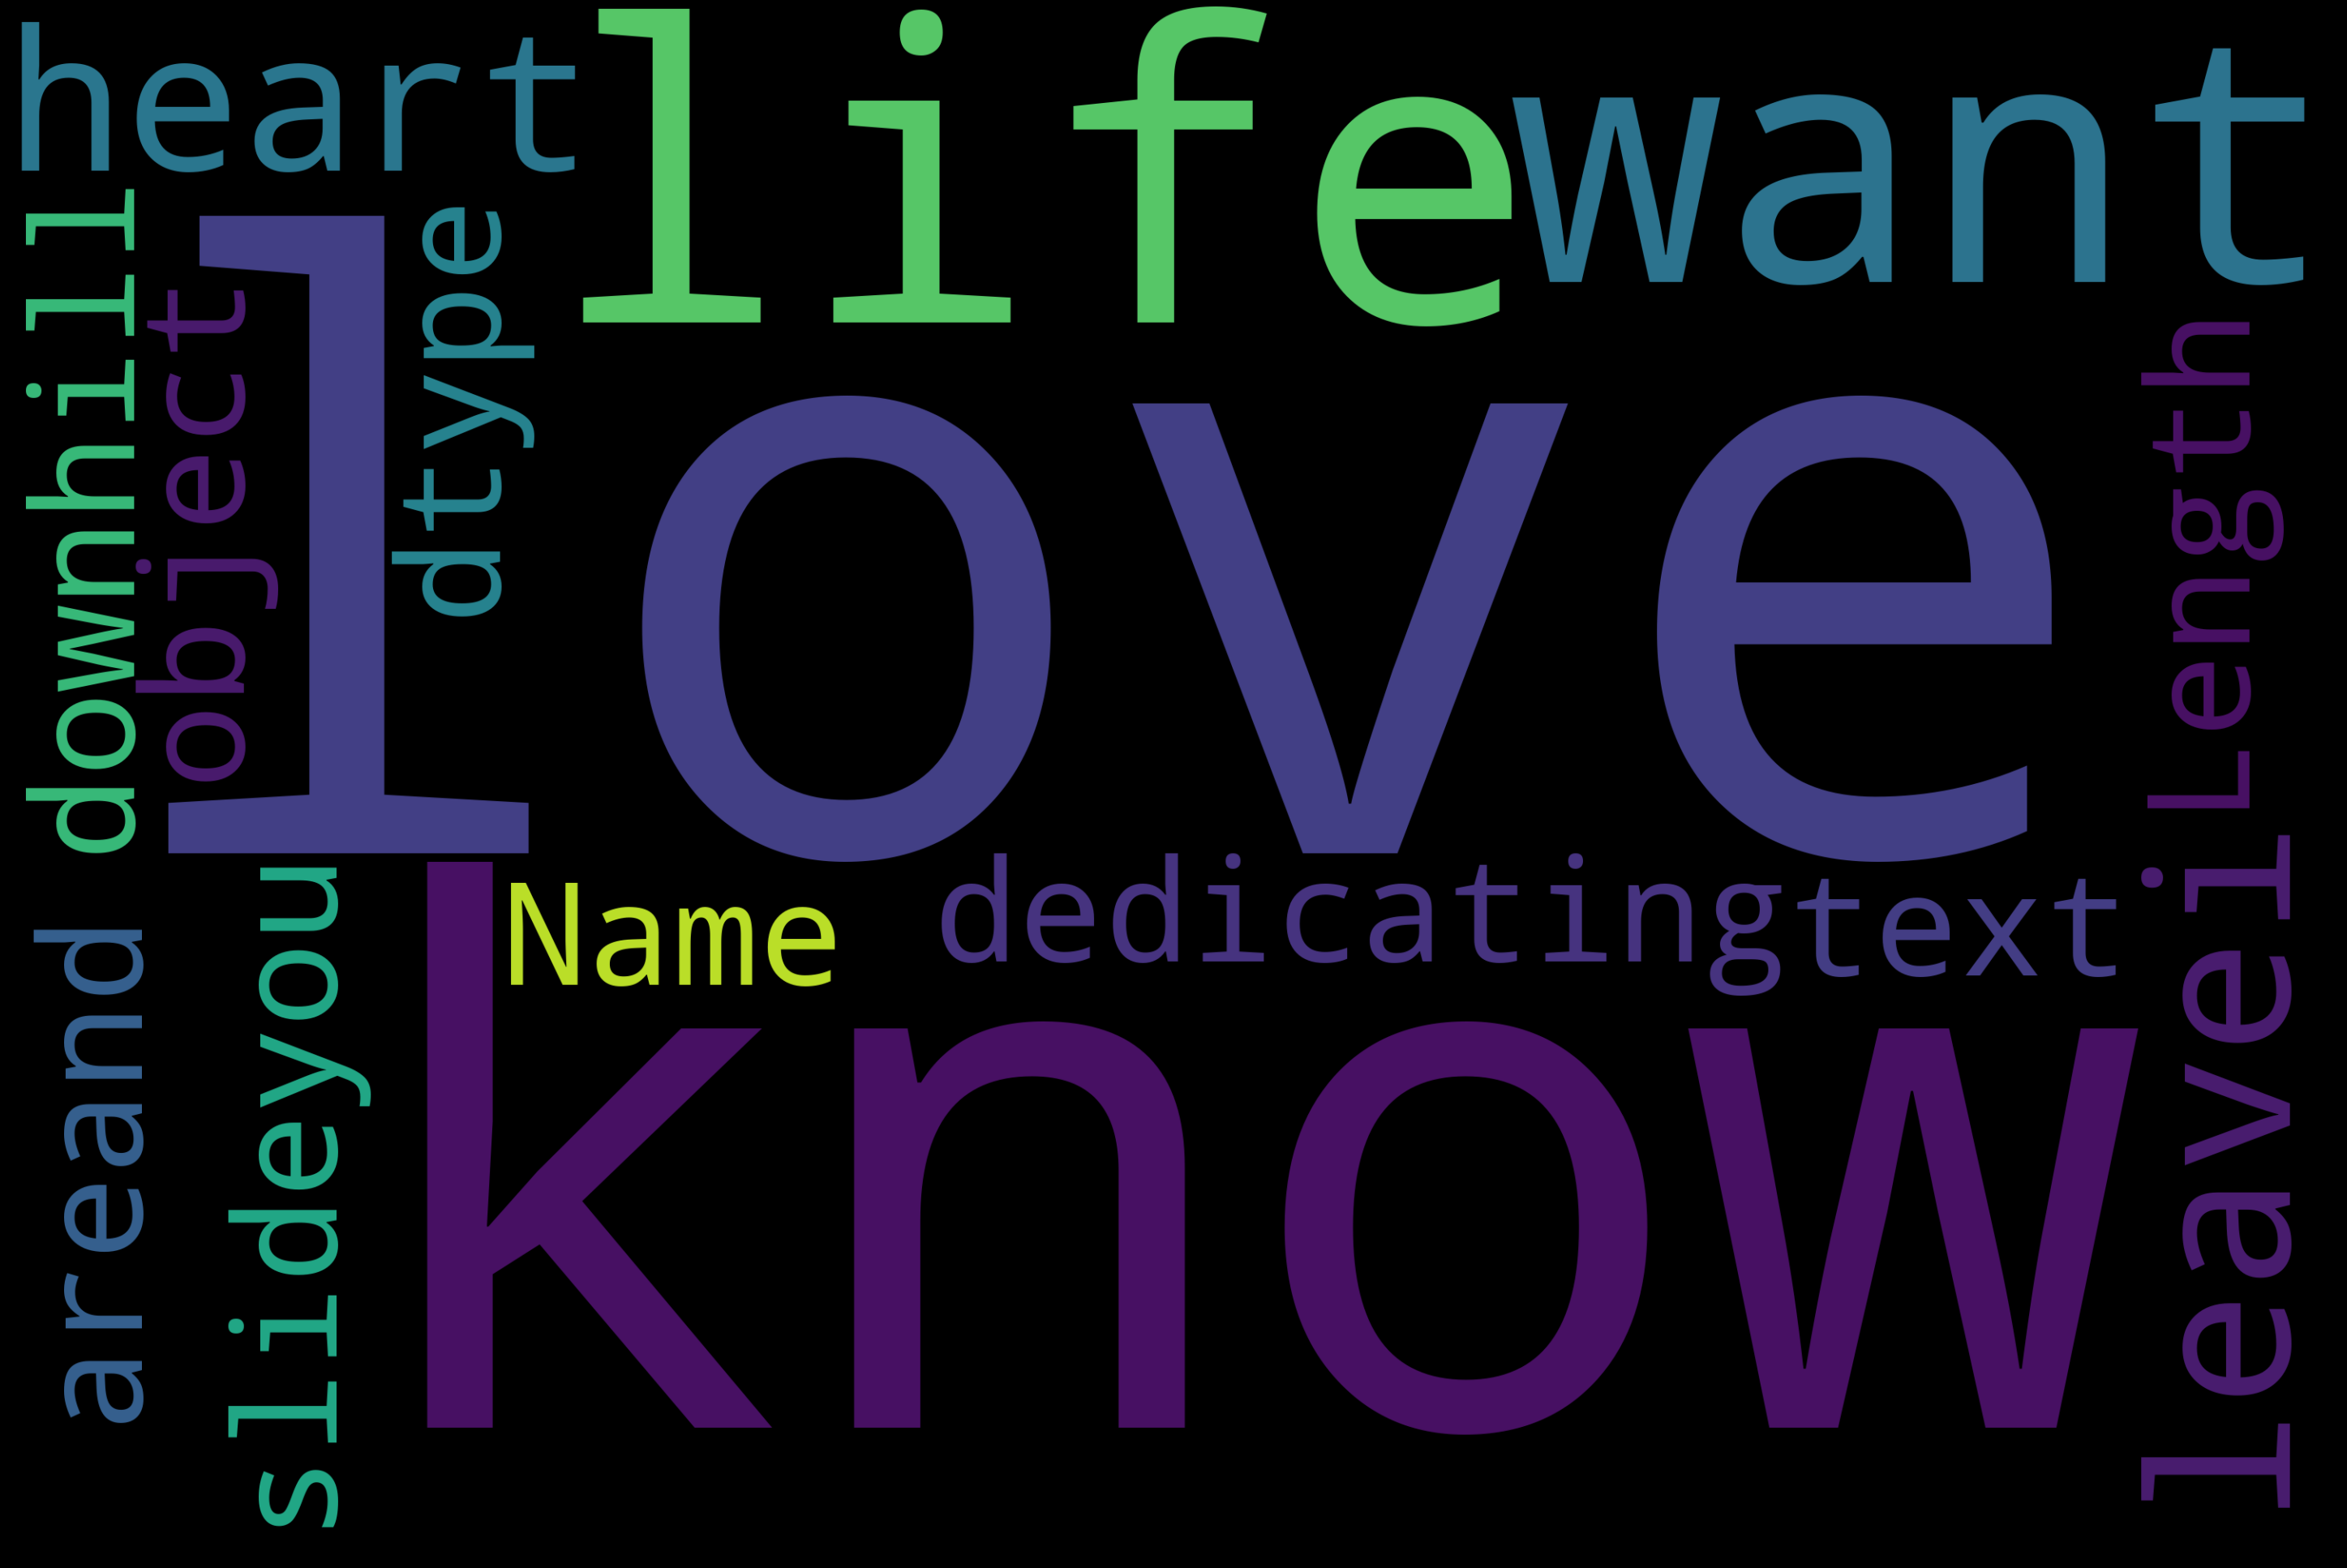

In [155]:
#initialize word cloud of love letter
text = df_onlylove_words['text']
wordcloud = WordCloud(width = 3000,height = 2000, background_color = 'black', stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(figsize = (40, 30), facecolor = 'k', edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [159]:
#words from non-love letter are extracted
nonlove_words = get_top_n_words(clean_nonlove['text'])
df_nonlove_words = pd.DataFrame(nonlove_words,columns=('text','frequency'))

#calculating total words from non-love letter
total = 0
for word,freq in nonlove_words:
    total += freq
print("Total number of words in non-love letter:",total)

#plotting graph for top 20 words from non-love letter
list_nonlove = df_nonlove_words[:20]
df = pd.DataFrame(list_nonlove, columns=('text','frequency'))
df.groupby('text').sum()['frequency'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='frequency', linecolor='black', title='Top 20 words in non-love letters')

#print top 20 words from non-love letter
print(list_nonlove)

Total number of words in non-love letter: 52453


           text  frequency
0        please        479
1         would        415
2            us        359
3         thank        333
4          time        322
5           new        314
6          know        288
7          work        271
8   springfield        271
9         years        259
10         help        247
11         john        205
12         hope        204
13          may        203
14         jane        193
15         call        191
16   appreciate        190
17     enclosed        185
18          one        180
19         like        180


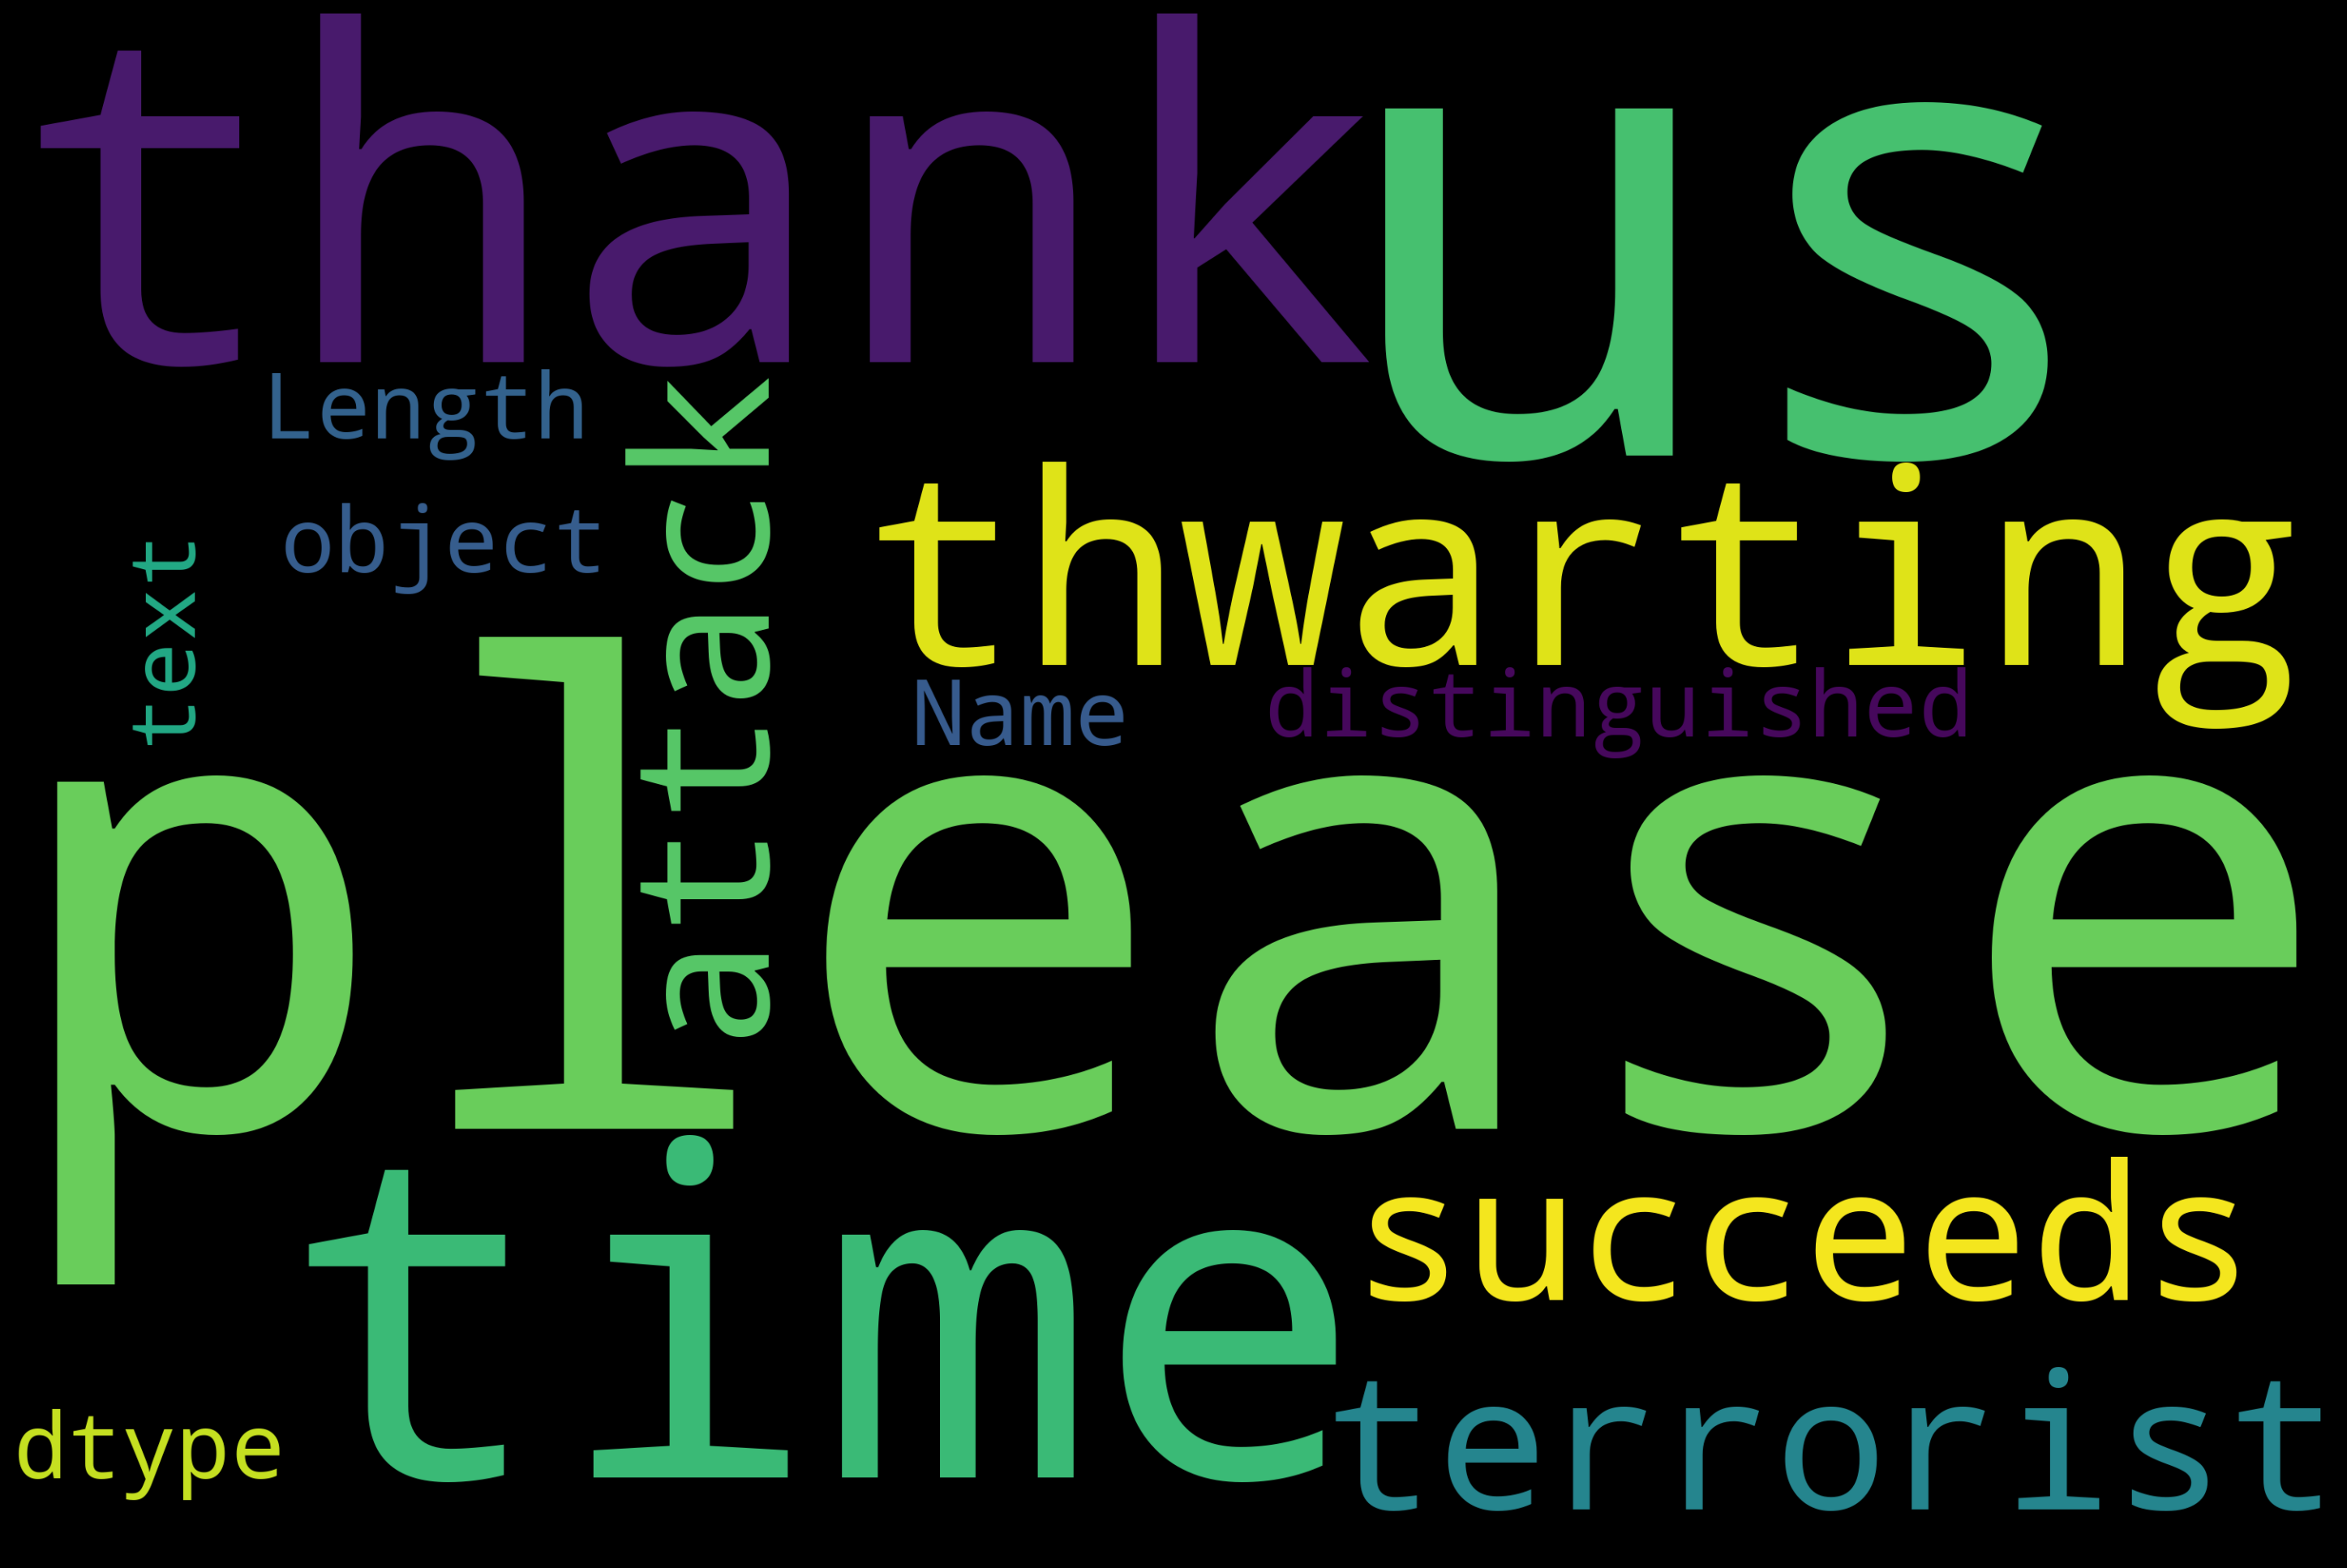

In [157]:
#initialize word cloud of non-love letter
text = df_nonlove_words["text"]
wordcloud = WordCloud(width = 3000, height = 2000, background_color = 'black', stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(figsize = (40, 30), facecolor = 'k', edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [160]:
#getting the labels (love or non-love letter) from dataset 
y = clean_letter.labels

In [161]:
#splitting data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(clean_letter['text'],y,test_size=0.33,random_state=53)

#initialize count vectorizer
count_vectorizer = CountVectorizer(stop_words="english")

#transform string data into bag-of-words
count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)

#calculating number of words in vocabulary (vector)
print("Words in vocabulary: ",len(count_vectorizer.vocabulary_))
print(count_vectorizer.vocabulary_)

Words in vocabulary:  9567
{'government': 3658, 'eased': 2638, 'import': 4187, 'tariffs': 8329, 'wool': 9383, 'products': 6466, 'negotiated': 5560, 'new': 5579, 'agreement': 244, 'australian': 616, 'supplier': 8205, 'pleased': 6207, 'pass': 5989, 'savings': 7325, 'anticipate': 392, 'prices': 6408, 'winter': 9334, 'clothing': 1487, 'reduced': 6811, 'receive': 6760, 'price': 6404, 'catalog': 1245, 'near': 5530, 'future': 3518, 'meantime': 5179, 'rest': 7080, 'assured': 571, 'effect': 2667, 'orders': 5827, 'postmarked': 6309, 'september': 7469, 'pleasure': 6214, 'meet': 5197, 'needs': 5547, 'quality': 6615, 'wear': 9209, 'lowest': 5012, 'possible': 6295, 'love': 4981, 'best': 840, 'friend': 3447, 'confidante': 1697, 'unitedunited': 8898, 'unlike': 8910, 'experienced': 3013, 'grateful': 3694, 'blessedyou': 910, 'amaze': 312, 'make': 5072, 'dance': 2044, 'walk': 9137, 'sing': 7662, 'talked': 8314, 'horizon': 4049, 'room': 7212, 'teach': 8346, 'bewhen': 853, 'fell': 3187, 'taught': 8338, 'bl

In [163]:
alphas = np.linspace(0,1,1000)

#calculate accuracy score for each alpha
def train_and_predict(alpha):
    
    # Instantiate the classifier and alpha 
    nb_classifier = MultinomialNB(alpha=alpha)
   
    # Fit to the training data
    nb_classifier.fit(count_train,y_train)
    
    # Predict the labels: pred
    pred = nb_classifier.predict(count_test)
    
    # Compute accuracy: score
    score = metrics.accuracy_score(y_test,pred)
    return score


C:\Users\Shin\anaconda3\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning:

alpha too small will result in numeric errors, setting alpha = 1.0e-10



Highest accuracy: 0.989010989010989 
Alpha: 0.009009009009009009


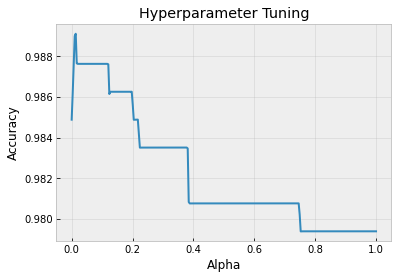

In [164]:
list_alpha = []
list_score = []
highest = 0
high_alpha = 0

#determine the most suitable alpha by choosing the highest accuracy one
for alpha in alphas:
    list_alpha.append(alpha)
    temp = train_and_predict(alpha)
    list_score.append(temp)
    if temp > highest:
        highest = temp
        high_alpha = alpha

#print the alpha chosen and its accuracy
print("Highest accuracy:",highest,"\nAlpha:",high_alpha)

#plotting the result of accuracy from each iteration
x = np.array(list_alpha)
y = np.array(list_score)
x_new = np.linspace(0,1,300)
a_BSpline = make_interp_spline(list_alpha, list_score, k=3)
y_new = a_BSpline(x_new)
plt.title('Hyperparameter Tuning')
plt.grid(alpha=.5,linestyle='-')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.plot(x_new, y_new)
plt.show()

In [165]:
#initialize training model using the alpha determined
nb_classifier = MultinomialNB(alpha = high_alpha)

#train the model
nb_classifier.fit(count_train,y_train)

#predict how well does the model do 
pred = nb_classifier.predict(count_test)

#get accuracy score
metrics.accuracy_score(y_test,pred)

0.989010989010989

In [166]:
#function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

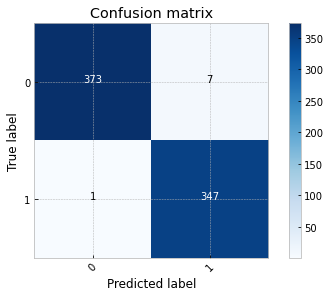

In [167]:
#getting value for confusion matrix
cm = metrics.confusion_matrix(y_test,pred,labels=[0,1])

#plot confusion matrix
plot_confusion_matrix(cm, classes=['0','1'])

In [168]:
#print the accuracy score
print('accuracy %s' % metrics.accuracy_score(pred, y_test),"\n")

#print the classification report
print(classification_report(y_test, pred))

accuracy 0.989010989010989 

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       380
           1       0.98      1.00      0.99       348

    accuracy                           0.99       728
   macro avg       0.99      0.99      0.99       728
weighted avg       0.99      0.99      0.99       728



In [141]:
#initialise variables for UI
btn = widgets.Button(description='Identify now!')
text = widgets.Text(placeholder="Enter your letter",description="Letter:")

#display the UI
display(text)
display(btn)

#function that get input from user and predict the meaning of the letter
def predict_letter(text):
    test_series = pd.Series(text)
    ct_test = count_vectorizer.transform(test_series)
    score = nb_classifier.predict(ct_test)
    if score == 1:
        return "Love <3"
    else:
        return "Nope, just get lost"
    
#print the result after button clicked by user
def btn_eventhandler(obj):
    print(predict_letter(text.value))
    
#handle the event for button clicked
btn.on_click(btn_eventhandler)


Text(value='', description='Letter:', placeholder='Enter your letter')

Button(description='Identify now!', style=ButtonStyle())